In [1]:
# Import, Preprocess
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api


# Base Model Structures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

# Model Modifications
from tensorflow.keras.layers import Dropout


# Hyper-parameter Tuning
import keras_tuner as kt

# Evaluation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
np.random.seed(2319)
tf.random.set_seed(23219) 

Load the data 

In [4]:
X_train = pd.read_csv("../data/X_train.csv")
X_test = pd.read_csv("../data/X_test.csv")
y_train = pd.read_csv("../data/y_train.csv")
y_test = pd.read_csv("../data/y_test.csv")

X_train = X_train.text 
X_test = X_test.text
y_train = y_train.Dominance.astype('category')
y_test = y_test.Dominance.astype('category')

# Pre-processing

## Load word2Vec embeddings

In [5]:
word2vec_model = api.load("word2vec-google-news-300")

In [6]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = 150
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_train_lab = label_encoder.fit_transform(y_train)

X_test_sequences = tokenizer.texts_to_sequences(X_test) 
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

y_test_lab = label_encoder.transform(y_test)

# Create the embedding matrix
embedding_dim = 300  # Dimension of Word2Vec vectors
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        # If the word is not in the Word2Vec vocabulary, leave it as zero vector
        continue


## Test a model

In [7]:
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False))

    hp_dropout = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout))

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(GRU(units=hp_units))

    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(24, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Choice('beta_1', values=[0.9, 0.99, 0.999]) 
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [8]:
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=20, 
    directory='tuning',
    project_name='tuning_results',
    seed = 2319,
    executions_per_trial = 3
)

Reloading Tuner from tuning\tuning_results\tuner0.json


In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [10]:
tuner.search(X_train_pad, y_train_lab, 
             epochs=50,
             validation_split=0.2, 
             callbacks=[stop_early],
             batch_size=256)

Trial 20 Complete [00h 01m 11s]
val_accuracy: 0.3094390332698822

Best val_accuracy So Far: 0.7347100178400675
Total elapsed time: 00h 37m 27s


In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] 
print("Best Hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

Best Hyperparameters:
dropout_rate: 0.2
units: 224
learning_rate: 0.001
beta_1: 0.999


In [12]:
trials = tuner.oracle.trials
results = []
for trial_id, trial in trials.items():
    trial_data = trial.hyperparameters.values
    trial_data['trial_id'] = trial_id
    trial_data['score'] = trial.score
    trial_data['status'] = trial.status
    results.append(trial_data)

df = pd.DataFrame(results)

# Display the DataFrame
print(df)

    dropout_rate  units  learning_rate  beta_1 trial_id     score     status
0            0.3    512         0.0010   0.990       01  0.727194  COMPLETED
1            0.3     96         0.0001   0.990       05  0.370441  COMPLETED
2            0.1     96         0.1000   0.990       03  0.494343  COMPLETED
3            0.0    256         0.0100   0.999       00  0.274389  COMPLETED
4            0.2    256         0.0010   0.990       04  0.724187  COMPLETED
5            0.2    224         0.0010   0.999       06  0.734710  COMPLETED
6            0.0    128         0.0010   0.900       02  0.716908  COMPLETED
7            0.1    512         0.0010   0.990       07  0.723950  COMPLETED
8            0.2    480         0.0001   0.990       08  0.711923  COMPLETED
9            0.1    480         0.0001   0.999       09  0.708126  COMPLETED
10           0.2    256         0.0001   0.990       10  0.696258  COMPLETED
11           0.2    160         0.0010   0.999       11  0.731941  COMPLETED

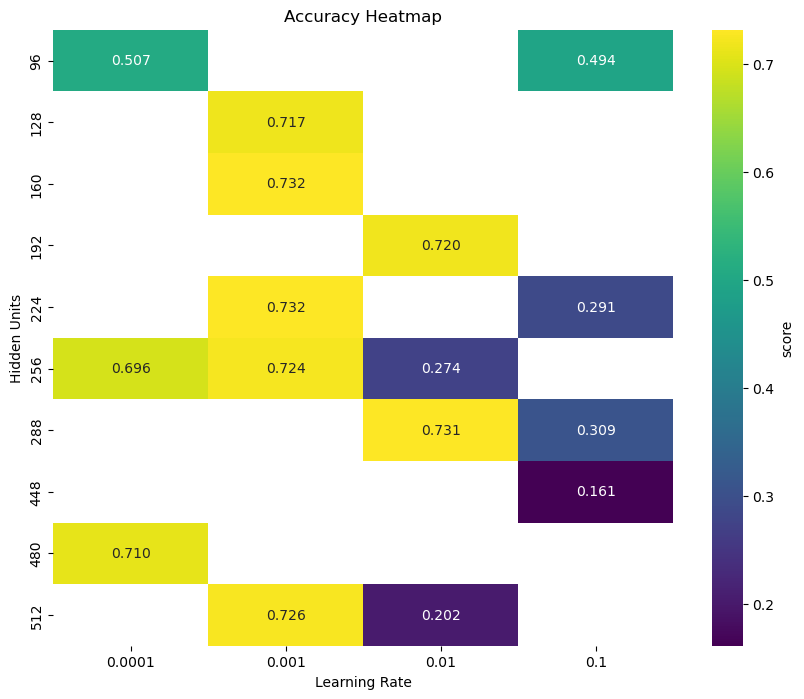

In [16]:
lr_by_units = df.pivot_table(
    index='units',
    columns='learning_rate',
    values='score', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(lr_by_units, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'score'})
plt.title('Accuracy Heatmap')
plt.xlabel('Learning Rate')
plt.ylabel('Hidden Units')
plt.show()

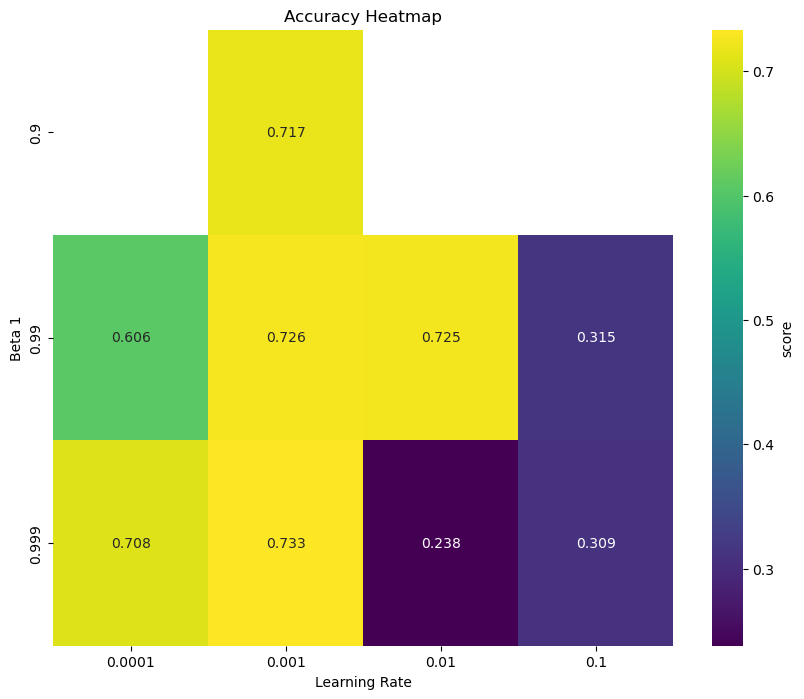

In [17]:
lr_by_units = df.pivot_table(
    index='beta_1',
    columns='learning_rate',
    values='score', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(lr_by_units, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'score'})
plt.title('Accuracy Heatmap')
plt.xlabel('Learning Rate')
plt.ylabel('Beta 1')
plt.show()

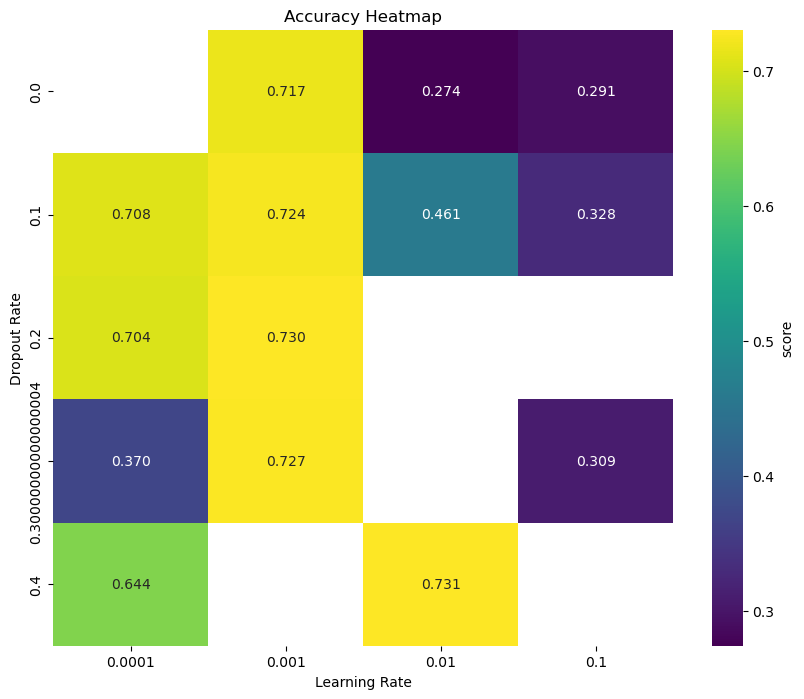

In [18]:
lr_by_units = df.pivot_table(
    index='dropout_rate',
    columns='learning_rate',
    values='score', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(lr_by_units, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'score'})
plt.title('Accuracy Heatmap')
plt.xlabel('Learning Rate')
plt.ylabel('Dropout Rate')
plt.show()

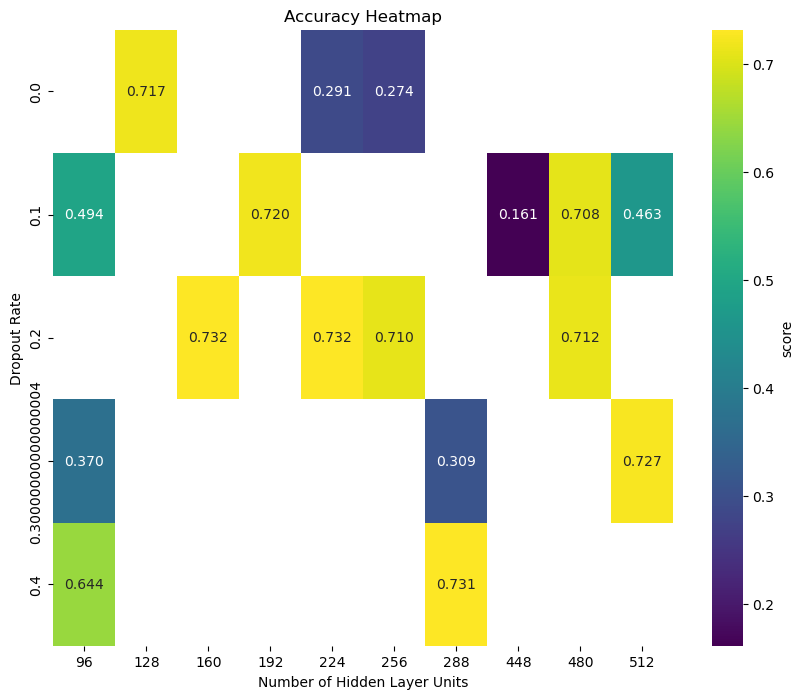

In [19]:
lr_by_units = df.pivot_table(
    index='dropout_rate',
    columns='units',
    values='score', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(lr_by_units, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'score'})
plt.title('Accuracy Heatmap')
plt.xlabel('Number of Hidden Layer Units')
plt.ylabel('Dropout Rate')
plt.show()

In [23]:
df.sort_values('score', ascending=False)

,dropout_rate,units,learning_rate,beta_1,trial_id,score,status
5,0.2,224,0.0010,0.999,06,0.734710,COMPLETED
11,0.2,160,0.0010,0.999,11,0.731941,COMPLETED
13,0.4,288,0.0100,0.990,13,0.730675,COMPLETED
16,0.2,224,0.0010,0.990,16,0.728855,COMPLETED
0,0.3,512,0.0010,0.990,01,0.727194,COMPLETED
4,0.2,256,0.0010,0.990,04,0.724187,COMPLETED
7,0.1,512,0.0010,0.990,07,0.723950,COMPLETED
12,0.1,192,0.0100,0.990,12,0.719915,COMPLETED
6,0.0,128,0.0010,0.900,02,0.716908,COMPLETED
8,0.2,480,0.0001,0.990,08,0.711923,COMPLETED
